In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.dates import MonthLocator, DateFormatter


client = bigquery.Client()  
year=2024 #se puede cambiar el año por el que quieras entre 2020 y 2025
# en caso de cambiar el año se recomienda reiniciar el kernel
# para evitar errores de cache
query = f"""
SELECT *
FROM `bigquery-public-data.noaa_gsod.gsod{year}`
"""

df = client.query(query).to_dataframe()
df.head()



,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,010020,99999,2024-11-15,2024,11,15,26.1,4,18.6,4,...,None,0.0,I,999.9,0,0,0,0,0,0
1,010060,99999,2024-06-21,2024,06,21,30.4,4,29.1,4,...,None,0.0,I,999.9,0,0,0,0,0,0
2,010170,99999,2024-10-20,2024,10,20,43.2,4,38.4,4,...,None,0.0,I,999.9,0,0,0,0,0,0
3,010170,99999,2024-12-05,2024,12,05,21.6,4,14.9,4,...,None,0.0,I,999.9,0,0,0,0,0,0
4,010430,99999,2024-06-17,2024,06,17,63.3,4,9999.9,0,...,None,0.0,I,999.9,0,0,0,0,0,0


In [2]:
# lista de comlumnas que no sean necesarias
columnas_a_eliminar = [
     'stn','wban', 'flag_prcp', 'flag_min', 
    'slp', 'visib', 'count_visib', 'count_wdsp', 
    'flag_max', 'year', 'mo', 'da' , 'count_temp', 'dewp','count_dewp',
    'count_slp','stp','sndp','gust', 'mxpsd','count_stp'

]

# elimina las columnas anteriormente mencionadas del dataframe si es que existen
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns], errors='ignore')


df.head()

,date,temp,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,2024-11-15,26.1,23.1,28.8,24.6,0.0,0,0,0,0,0,0
1,2024-06-21,30.4,4.9,32.4,28.8,0.0,0,0,0,0,0,0
2,2024-10-20,43.2,9.2,46.9,38.1,0.0,0,0,0,0,0,0
3,2024-12-05,21.6,21.5,24.8,16.3,0.0,0,0,0,0,0,0
4,2024-06-17,63.3,13.1,67.8,60.6,0.0,0,0,0,0,0,0


In [3]:


# Lista de variables meteorológicas
variables = ['fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder', 'tornado_funnel_cloud']
# si la columna 'date' existe en el dataframe, la convierte a tipo fecha y la ordena de manera ascendente

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
    df = df.sort_values('date').assign(date=lambda x: x['date'].dt.strftime('%d/%m/%Y'))
    display(df.head())

,date,temp,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
1732753,01/01/2024,42.2,3.4,55.2,25.5,0.00,0,0,0,0,0,0
13405,01/01/2024,-1.3,3.9,9.5,-22.2,0.02,0,0,1,0,0,0
2607804,01/01/2024,42.4,6.4,53.1,32.0,0.00,0,0,0,0,0,0
3145998,01/01/2024,68.9,6.3,81.0,52.0,0.00,1,0,0,0,0,0
208089,01/01/2024,48.7,2.5,52.5,45.9,0.00,1,1,0,0,0,0


In [4]:
# Conversión y conteo en una línea por columna
resultados = {
    col: int(pd.to_numeric(df[col], errors='coerce').eq(1).sum())
    for col in variables if col in df.columns
}

# Mostrar como DataFrame
pd.DataFrame.from_dict(resultados, orient='index', columns=['Ocurrencias'])

,Ocurrencias
fog,217755
rain_drizzle,968620
snow_ice_pellets,234571
hail,4473
thunder,173891
tornado_funnel_cloud,206


In [5]:

# Lista de variables meteorológicas
variables = ['fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder', 'tornado_funnel_cloud']

# 1. Convertir las columnas a numérico
for col in variables:
    if col in df.columns:
        # Convertir a string primero por si hay valores mixtos, luego a numérico
        df[col] = pd.to_numeric(df[col].astype(str), errors='coerce')
    else:
        print(f"Advertencia: Columna {col} no encontrada en el DataFrame")

# 2. Contar ocurrencias donde el valor es exactamente 1
conteos = {}
for var in variables:
    if var in df.columns:
        # Contar valores iguales a 1 (ignorando NaN)
        conteo = df[var].eq(1).sum()
        conteos[var] = int(conteo)  # Convertir a entero estándar

# 3. Mostrar resultados en formato claro
print("═"*60)
print(" RESUMEN DE OCURRENCIAS METEOROLÓGICAS ".center(60))
print("═"*60)
print(f"{'Evento':<25} | {'Ocurrencia':>10} | {'Porcentaje':>10}")
print("-"*60)

total_registros = len(df)
for evento, cantidad in conteos.items():
    porcentaje = (cantidad / total_registros) * 100 if total_registros > 0 else 0
    print(f"{evento.replace('_', ' ').title():<25} | {cantidad:>10,} | {porcentaje:>9.2f}%")

# 4. Crear DataFrame con resultados
df_resultados = pd.DataFrame.from_dict(conteos, orient='index', columns=['eventos'])
df_resultados['Porcentaje'] = (df_resultados['eventos'] / total_registros * 100).round(2)
print("\nTabla resumen:")
display(df_resultados.sort_values('eventos', ascending=False))

════════════════════════════════════════════════════════════
           RESUMEN DE OCURRENCIAS METEOROLÓGICAS            
════════════════════════════════════════════════════════════
Evento                    | Ocurrencia | Porcentaje
------------------------------------------------------------
Fog                       |    217,755 |      5.64%
Rain Drizzle              |    968,620 |     25.10%
Snow Ice Pellets          |    234,571 |      6.08%
Hail                      |      4,473 |      0.12%
Thunder                   |    173,891 |      4.51%
Tornado Funnel Cloud      |        206 |      0.01%

Tabla resumen:


,eventos,Porcentaje
rain_drizzle,968620,25.10
snow_ice_pellets,234571,6.08
fog,217755,5.64
thunder,173891,4.51
hail,4473,0.12
tornado_funnel_cloud,206,0.01


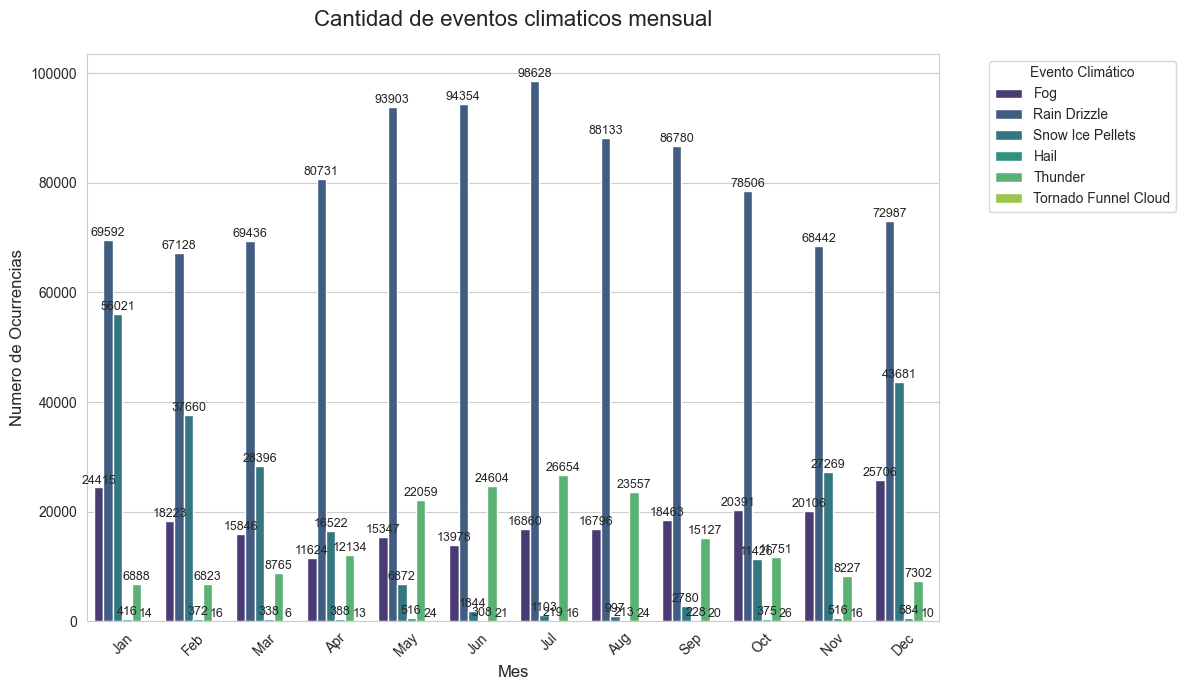

In [6]:

# 1. Verificar y preparar los datos
if 'date' not in df.columns:
    print("Error: No se encuentra la columna 'date'")
else:
    try:
        # Convertir fecha considerando el formato dd/mm/YYYY
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
        
        # Eliminar filas con fechas inválidas si las hay
        if df['date'].isna().any():
            print(f"Advertencia: Se eliminaron {df['date'].isna().sum()} filas con fechas inválidas")
            df = df.dropna(subset=['date'])
        
        # Extraer mes y nombre del mes
        df['month'] = df['date'].dt.month
        df['month_name'] = df['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
        
        # 2. Procesar eventos climáticos
        eventos = ['fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder', 'tornado_funnel_cloud']
        eventos = [e for e in eventos if e in df.columns]  # Solo eventos existentes
        
        # Calcular ocurrencias por mes para cada evento
        datos_grafico = []
        for evento in eventos:
            temp_df = df[df[evento] == 1].groupby(['month', 'month_name']).size().reset_index(name='count')
            temp_df['evento'] = evento.replace('_', ' ').title()
            datos_grafico.append(temp_df)
        
        df_grafico = pd.concat(datos_grafico)
        
        # 3. Crear el gráfico
        plt.figure(figsize=(12, 7))
        sns.set_style("whitegrid")
        
        # Ordenar los meses cronológicamente
        month_order = [calendar.month_abbr[i] for i in range(1, 13)]
        df_grafico['month_name'] = pd.Categorical(df_grafico['month_name'], categories=month_order, ordered=True)
        
        # Gráfico de barras
        ax = sns.barplot(
            data=df_grafico,
            x='month_name',
            y='count',
            hue='evento',
            palette='viridis',
            order=month_order
        )
        
        # Personalización
        plt.title('Cantidad de eventos climaticos mensual', fontsize=16, pad=20)
        plt.xlabel('Mes', fontsize=12)
        plt.ylabel('Numero de Ocurrencias', fontsize=12)
        plt.legend(title='Evento Climático', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Añadir valores a las barras
        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(
                    f"{int(p.get_height())}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=9
                )
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error al generar el gráfico: {str(e)}")

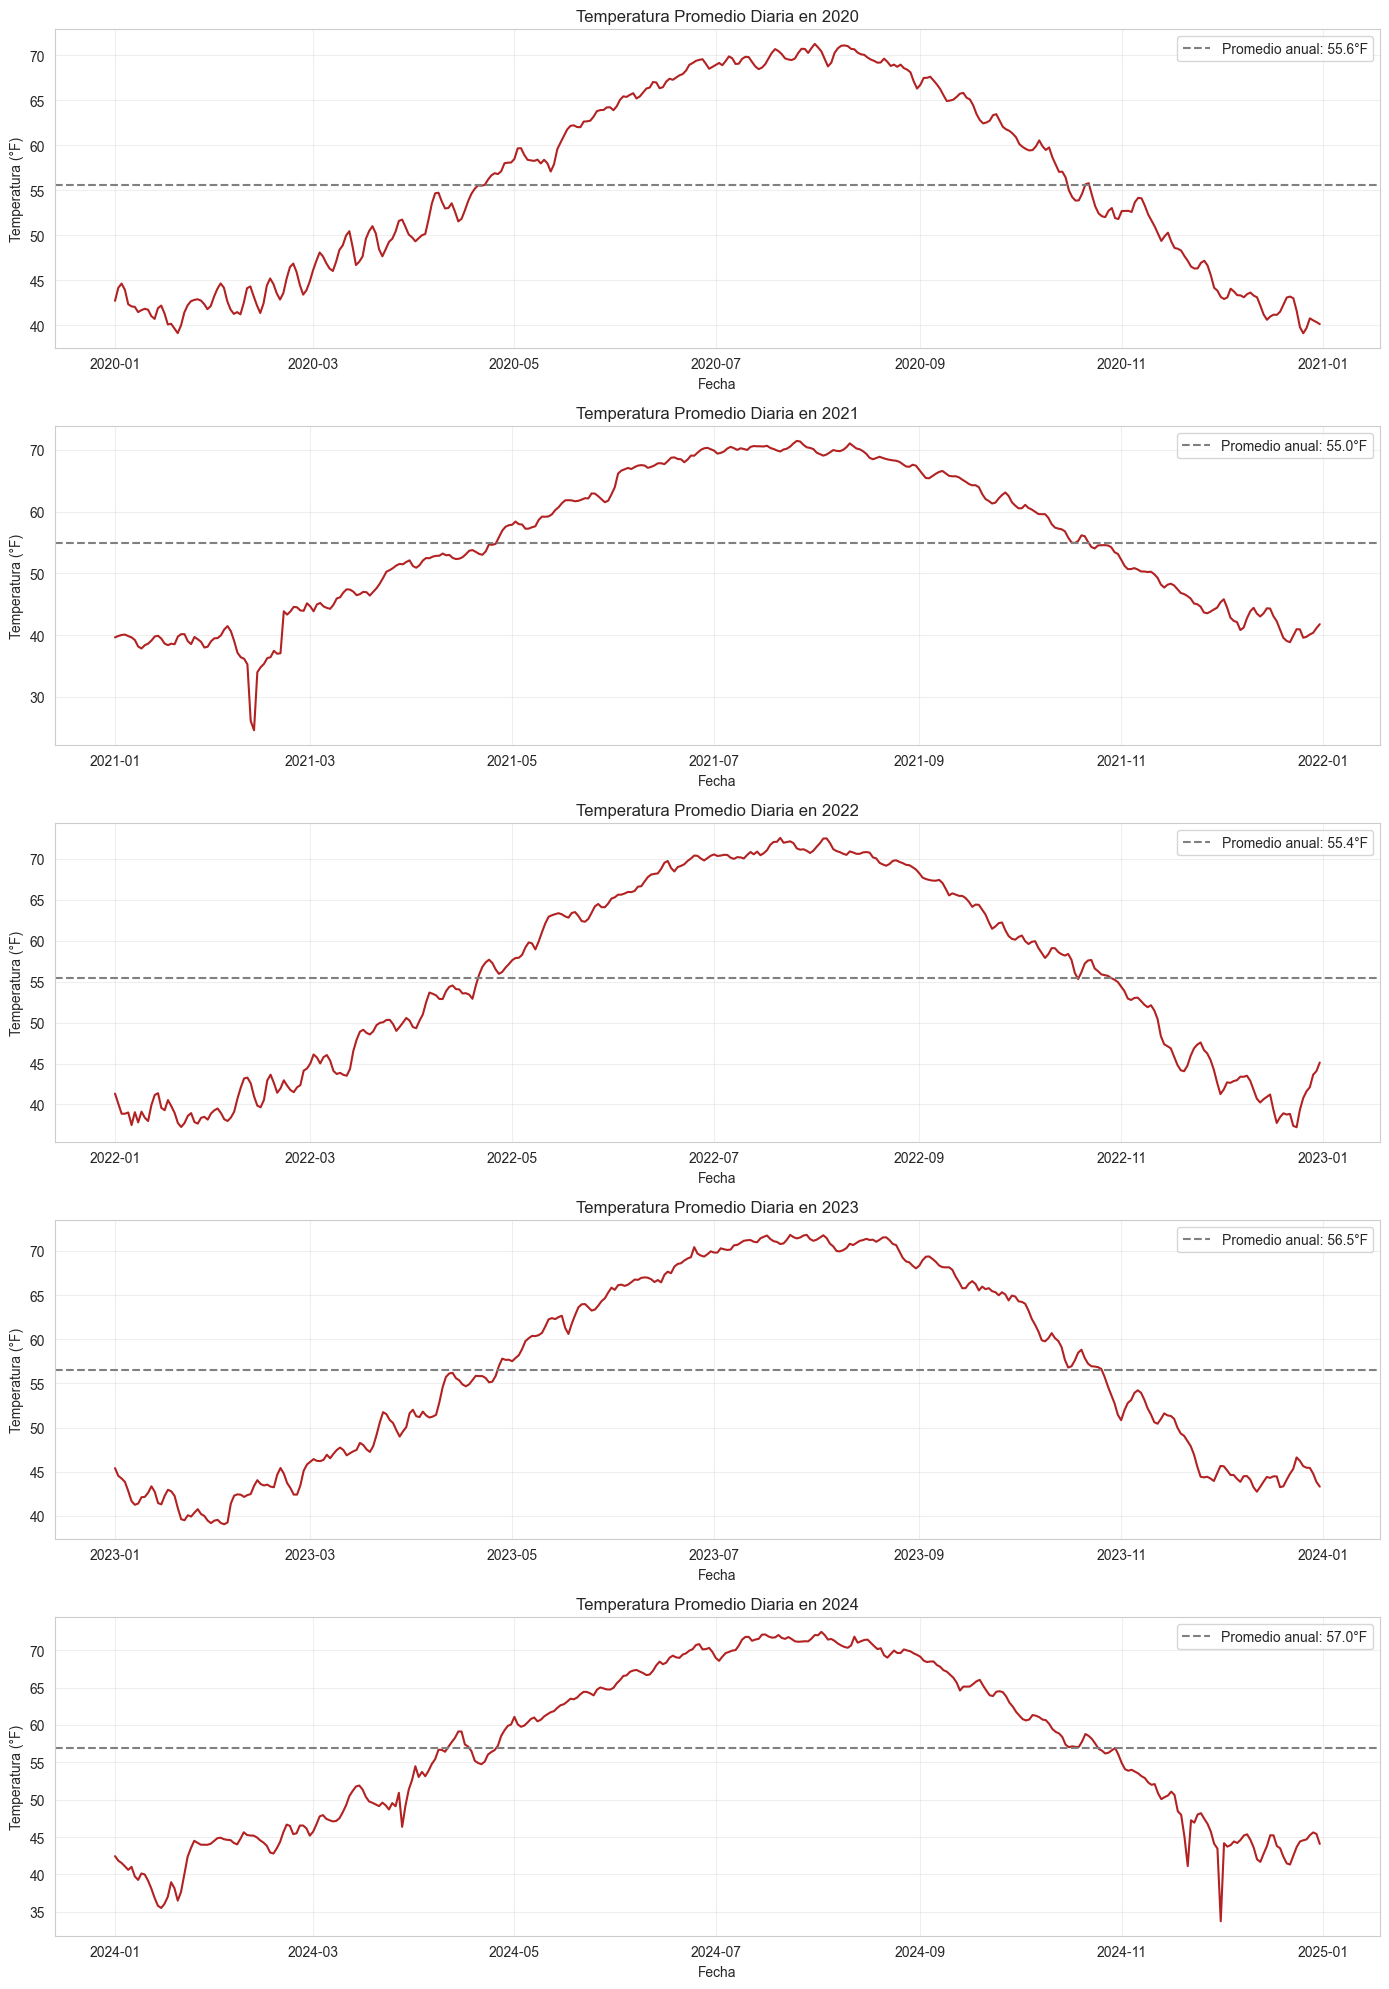

In [7]:


# Configuración inicial
client = bigquery.Client()

# Función para obtener y procesar datos de un año específico
def get_year_data(year):
    query = f"""
    SELECT date, temp  # Solo seleccionamos las columnas necesarias
    FROM `bigquery-public-data.noaa_gsod.gsod{year}`
    WHERE date BETWEEN '{year}-01-01' AND '{year}-12-31'
    """
    
    df = client.query(query).to_dataframe()
    df = df.rename(columns={'date': 'Fecha'})
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values('Fecha', ascending=True).reset_index(drop=True)
    return df

# Crear una figura con subgráficos
fig, axes = plt.subplots(5, 1, figsize=(14, 20))

# Lista de años a analizar
years = [2020, 2021, 2022, 2023, 2024]

# Generar gráfico para cada año
for i, year in enumerate(years):
    # Obtener datos del año
    df_year = get_year_data(year)
    
    # Crear gráfico en el subplot correspondiente
    sns.lineplot(
        data=df_year,
        x='Fecha',
        y='temp',
        estimator='mean',
        errorbar=None,
        color='firebrick',
        ax=axes[i]
    )
    
    # Personalizar cada subgráfico
    axes[i].set_title(f'Temperatura Promedio Diaria en {year}', fontsize=12)
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Temperatura (°F)')
    axes[i].grid(alpha=0.3)
    axes[i].axhline(
        y=df_year['temp'].mean(), 
        color='gray', 
        linestyle='--', 
        label=f'Promedio anual: {df_year["temp"].mean():.1f}°F'
    )
    axes[i].legend()

plt.tight_layout()
plt.show()
